<a href="https://colab.research.google.com/github/harshdsdh/sparseLP/blob/main/Without_crossnodetendency_Baseline_karate_cora_networkx_algos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install networkx

In [2]:
import networkx as nx
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import random


In [3]:
### Load Karate club
G = nx.karate_club_graph()

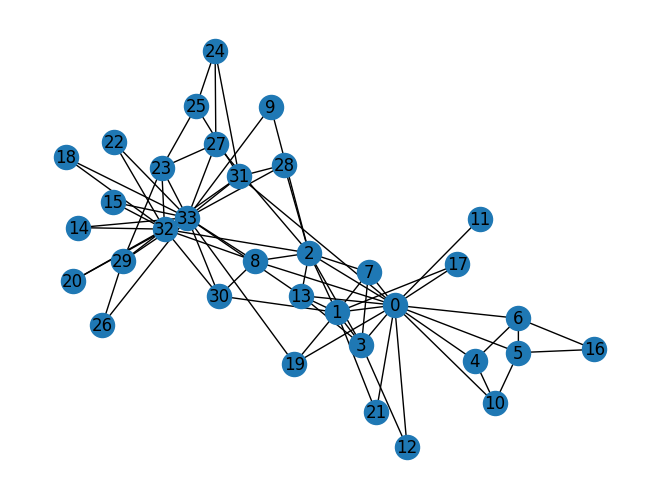

In [4]:
nx.draw_spring(G, with_labels=True)

In [5]:
all_edges = list(G.edges())
all_edges

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 7),
 (0, 8),
 (0, 10),
 (0, 11),
 (0, 12),
 (0, 13),
 (0, 17),
 (0, 19),
 (0, 21),
 (0, 31),
 (1, 2),
 (1, 3),
 (1, 7),
 (1, 13),
 (1, 17),
 (1, 19),
 (1, 21),
 (1, 30),
 (2, 3),
 (2, 7),
 (2, 8),
 (2, 9),
 (2, 13),
 (2, 27),
 (2, 28),
 (2, 32),
 (3, 7),
 (3, 12),
 (3, 13),
 (4, 6),
 (4, 10),
 (5, 6),
 (5, 10),
 (5, 16),
 (6, 16),
 (8, 30),
 (8, 32),
 (8, 33),
 (9, 33),
 (13, 33),
 (14, 32),
 (14, 33),
 (15, 32),
 (15, 33),
 (18, 32),
 (18, 33),
 (19, 33),
 (20, 32),
 (20, 33),
 (22, 32),
 (22, 33),
 (23, 25),
 (23, 27),
 (23, 29),
 (23, 32),
 (23, 33),
 (24, 25),
 (24, 27),
 (24, 31),
 (25, 31),
 (26, 29),
 (26, 33),
 (27, 33),
 (28, 31),
 (28, 33),
 (29, 32),
 (29, 33),
 (30, 32),
 (30, 33),
 (31, 32),
 (31, 33),
 (32, 33)]

In [6]:
all_edges = list(G.edges())
kf = KFold(n_splits = 10, shuffle=True, random_state=42)
kf.split(all_edges)

<generator object _BaseKFold.split at 0x7eecd5716440>

In [7]:
for fold, (train_idx, test_idx) in enumerate(kf.split(all_edges)):
        print(f"Processing fold {fold+1}/{10}")
        print(train_idx, test_idx)

Processing fold 1/10
[ 1  2  3  5  6  7  8  9 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 31 32 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76] [ 0  4 10 12 30 33 34 77]
Processing fold 2/10
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19 20 21 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 45 46 47 48 50 51
 52 53 55 56 57 58 59 60 62 63 64 65 67 68 69 70 71 73 74 75 76 77] [18 22 44 49 54 61 66 72]
Processing fold 3/10
[ 0  1  2  3  4  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 32 33 34 36 37 38 40 41 42 43 44 45 46 47 48 49 50 51 52
 54 55 56 57 59 60 61 62 63 64 65 66 68 69 70 71 72 73 74 75 76 77] [ 5  9 31 35 39 53 58 67]
Processing fold 4/10
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 29 30 31 32 33 34 35 36 37 38 39 41 43 44 45 46 48 49 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 7

In [8]:
def generate_negative_samples(graph, train_graph, test_edges, negative_ratio=2, max_attempts=100000):
    non_edges = set()
    total_negative_elems = len(test_edges) * negative_ratio

    all_nodes = list(train_graph.nodes())
    attempts = 0

    while len(non_edges) < total_negative_elems and attempts < max_attempts:
        u = random.choice(all_nodes)
        v = random.choice(all_nodes)
        attempts += 1

        if u != v and not graph.has_edge(u, v) and (u, v) not in non_edges and (v, u) not in non_edges:
            non_edges.add((u, v))

    if len(non_edges) < total_negative_elems:
        print(f"Warning: Only generated {len(non_edges)} negative samples out of requested {total_negative_elems}")

    return list(non_edges)

In [9]:
def cross_node_tendency(graph, u,v, Cu, Cv):
  neighbors = list(graph.neighbors(u))
  return any(graph.nodes[n]['community'] == Cv for n in neighbors)

In [10]:
def hmishra_resource_alloc_1(train_graph, u,v):
  # baseline
  # if one node degree less than avg deg of its community , one node deg more than avg deg of its comm, they have diff community
  # then more bonus for common nodes

  s = [p for _,_, p in nx.ra_index_soundarajan_hopcroft(train_graph, [(u,v)])][0]

  u_deg = train_graph.degree(u)
  v_deg = train_graph.degree(v)

  Cu = train_graph.nodes[u].get('community')
  Cv = train_graph.nodes[v].get('community')
  if Cu == Cv:
      return s

  nodes_Cu = [n for n in train_graph.nodes if train_graph.nodes[n].get('community') == Cu]
  avg_degree_in_community_Cu = np.mean([train_graph.degree(n) for n in nodes_Cu]) if nodes_Cu else 0

  nodes_Cv = [n for n in train_graph.nodes if train_graph.nodes[n].get('community') == Cv]
  avg_degree_in_community_Cv = np.mean([train_graph.degree(n) for n in nodes_Cv]) if nodes_Cv else 0

  if u_deg < avg_degree_in_community_Cu and v_deg > avg_degree_in_community_Cv:
      bonus = len(list(nx.common_neighbors(train_graph, u, v)))
      return bonus + s
  elif v_deg < avg_degree_in_community_Cv and u_deg > avg_degree_in_community_Cu:
      bonus = len(list(nx.common_neighbors(train_graph, u, v)))
      return bonus + s

  return s



In [12]:
def hmishra_common_neighbor_1(train_graph , u,v):
  # baseline
  # if one node degree less than avg deg of its community , one node deg more than avg deg of its comm, they have diff community
  # then more bonus for common nodes

  s = [p for _,_, p in nx.cn_soundarajan_hopcroft(train_graph, [(u,v)])][0]

  u_deg = train_graph.degree(u)
  v_deg = train_graph.degree(v)

  Cu = train_graph.nodes[u].get('community')
  Cv = train_graph.nodes[v].get('community')
  if Cu == Cv:
      return s

  nodes_Cu = [n for n in train_graph.nodes if train_graph.nodes[n].get('community') == Cu]
  avg_degree_in_community_Cu = np.mean([train_graph.degree(n) for n in nodes_Cu]) if nodes_Cu else 0

  nodes_Cv = [n for n in train_graph.nodes if train_graph.nodes[n].get('community') == Cv]
  avg_degree_in_community_Cv = np.mean([train_graph.degree(n) for n in nodes_Cv]) if nodes_Cv else 0

  if u_deg < avg_degree_in_community_Cu and v_deg > avg_degree_in_community_Cv:
      bonus = len(list(nx.common_neighbors(train_graph, u, v)))
      return bonus + s
  elif v_deg < avg_degree_in_community_Cv and u_deg > avg_degree_in_community_Cu:
      bonus = len(list(nx.common_neighbors(train_graph, u, v)))
      return bonus + s

  return s




In [13]:
def get_baseline_scores(G, n_splits = 10):
  methods = {'resource_alloc': {'auc_scores': [], 'avg_precision_scores': [], 'vcmpr': []},
             'common_neighbor': {'auc_scores': [], 'avg_precision_scores': [], 'vcmpr':[]},
             'ra_index_soundarajan_hopcroft': {'auc_scores': [], 'avg_precision_scores': [], 'vcmpr': []},
             'cn_soundarajan_hopcroft': {'auc_scores': [], 'avg_precision_scores': [], 'vcmpr': []},
             'hmishra_resource_alloc_1': {'auc_scores': [], 'avg_precision_scores': [], 'vcmpr': []},
             'hmishra_common_neighbor_1': {'auc_scores': [], 'avg_precision_scores': [], 'vcmpr': []}
  }

  all_edges = list(G.edges())
  kf = KFold(n_splits, shuffle=True, random_state=42)
  for fold, (train_idx, test_idx) in enumerate(kf.split(all_edges)):
    print(f"fold {fold+1}/{n_splits}")
    G_train = nx.Graph()
    G_train.add_nodes_from(G.nodes())

    train_edges = [all_edges[i] for i in train_idx]
    test_edges = [all_edges[i] for i in test_idx]

    G_train.add_edges_from(train_edges)

    non_edges = generate_negative_samples(G, G_train, test_edges)

    test_set = test_edges + non_edges
    test_labels = [1]*len(test_edges) + [0]*len(non_edges)

    communities = nx.community.louvain_communities(G_train)

    # Map nodes to communities
    community_map = {}
    for i, comm in enumerate(communities):
        for node in comm:
            community_map[node] = i

    # Add community attribute to nodes
    for node in G_train.nodes():
        G_train.nodes[node]['community'] = community_map.get(node, 0)


    for method, (auc_scores, avg_precision_scores, vcmpr) in methods.items():
      if method == 'resource_alloc':
        test_score = [p for _,_,p in nx.resource_allocation_index(G_train, test_set)]
      elif method == 'common_neighbor':
        test_score = [p for _,_,p in nx.common_neighbor_centrality(G_train, test_set)]
      elif method == 'ra_index_soundarajan_hopcroft':
        test_score = [p for _,_,p in nx.ra_index_soundarajan_hopcroft(G_train, test_set)]
      elif method == 'cn_soundarajan_hopcroft':
        test_score = [p for _,_,p in nx.cn_soundarajan_hopcroft(G_train, test_set)]
      elif method == 'hmishra_resource_alloc_1':
        test_score = [hmishra_resource_alloc_1(G_train, u,v) for u,v in test_set]

      elif method == 'hmishra_common_neighbor_1':
        test_score = [hmishra_common_neighbor_1(G_train,u,v) for u,v in test_set]


      auc = roc_auc_score(test_labels, test_score)
      avg_precision = average_precision_score(test_labels, test_score)

      # Compute VCMPR@K
      K=10
      pairs_scores = list(zip(test_set, test_labels, test_score))
      by_node = {}
      for (u, v), label, score in pairs_scores:
          for node in (u, v):
              if node not in by_node:
                  by_node[node] = []
              by_node[node].append((score, label))

      node_precisions = []
      for node, pairs in by_node.items():
          sorted_pairs = sorted(pairs, key=lambda x: -x[0])[:K]
          if sorted_pairs:
              correct = sum(lab for _, lab in sorted_pairs)
              node_precisions.append(correct / K)

      methods[method]['vcmpr'].append(np.mean(node_precisions))

      methods[method]['auc_scores'].append(auc)
      methods[method]['avg_precision_scores'].append(avg_precision)
  return methods



In [14]:
methods_vals = get_baseline_scores(G, )

fold 1/10
fold 2/10
fold 3/10
fold 4/10
fold 5/10
fold 6/10
fold 7/10
fold 8/10
fold 9/10
fold 10/10


In [15]:
methods_vals

{'resource_alloc': {'auc_scores': [np.float64(0.640625),
   np.float64(0.7578125),
   np.float64(0.78125),
   np.float64(0.9375),
   np.float64(0.65234375),
   np.float64(0.703125),
   np.float64(0.546875),
   np.float64(0.88671875),
   np.float64(0.6632653061224489),
   np.float64(0.6428571428571428)],
  'avg_precision_scores': [np.float64(0.6666666666666666),
   np.float64(0.5720238095238095),
   np.float64(0.7333333333333334),
   np.float64(0.888188608776844),
   np.float64(0.5),
   np.float64(0.63125),
   np.float64(0.42534722222222215),
   np.float64(0.8404761904761905),
   np.float64(0.6285714285714286),
   np.float64(0.4946799232513518)],
  'vcmpr': [np.float64(0.06666666666666667),
   np.float64(0.06956521739130435),
   np.float64(0.06153846153846154),
   np.float64(0.06153846153846154),
   np.float64(0.06666666666666667),
   np.float64(0.05925925925925926),
   np.float64(0.06153846153846154),
   np.float64(0.055172413793103454),
   np.float64(0.06086956521739131),
   np.float6

In [16]:
results = {}

for method, metrics in methods_vals.items():
  avg_auc = np.mean(metrics['auc_scores'])
  avg_avg_precision = np.mean(metrics['avg_precision_scores'])
  vcmpr = np.mean(metrics['vcmpr'])

  results[method]={
      'auc':avg_auc,
      'avg_precision': avg_avg_precision,
      'vcmpr@K': vcmpr
  }

In [17]:
results

{'resource_alloc': {'auc': np.float64(0.7212372448979592),
  'avg_precision': np.float64(0.6380537182821846),
  'vcmpr@K': np.float64(0.06188151736097762)},
 'common_neighbor': {'auc': np.float64(0.6777822066326531),
  'avg_precision': np.float64(0.5733122751002008),
  'vcmpr@K': np.float64(0.06188151736097762)},
 'ra_index_soundarajan_hopcroft': {'auc': np.float64(0.623014987244898),
  'avg_precision': np.float64(0.523080357142857),
  'vcmpr@K': np.float64(0.06188151736097762)},
 'cn_soundarajan_hopcroft': {'auc': np.float64(0.6934709821428571),
  'avg_precision': np.float64(0.5505717607555842),
  'vcmpr@K': np.float64(0.06188151736097762)},
 'hmishra_resource_alloc_1': {'auc': np.float64(0.6916852678571429),
  'avg_precision': np.float64(0.5614912518037518),
  'vcmpr@K': np.float64(0.06188151736097762)},
 'hmishra_common_neighbor_1': {'auc': np.float64(0.705094068877551),
  'avg_precision': np.float64(0.5787439296814296),
  'vcmpr@K': np.float64(0.06188151736097762)}}

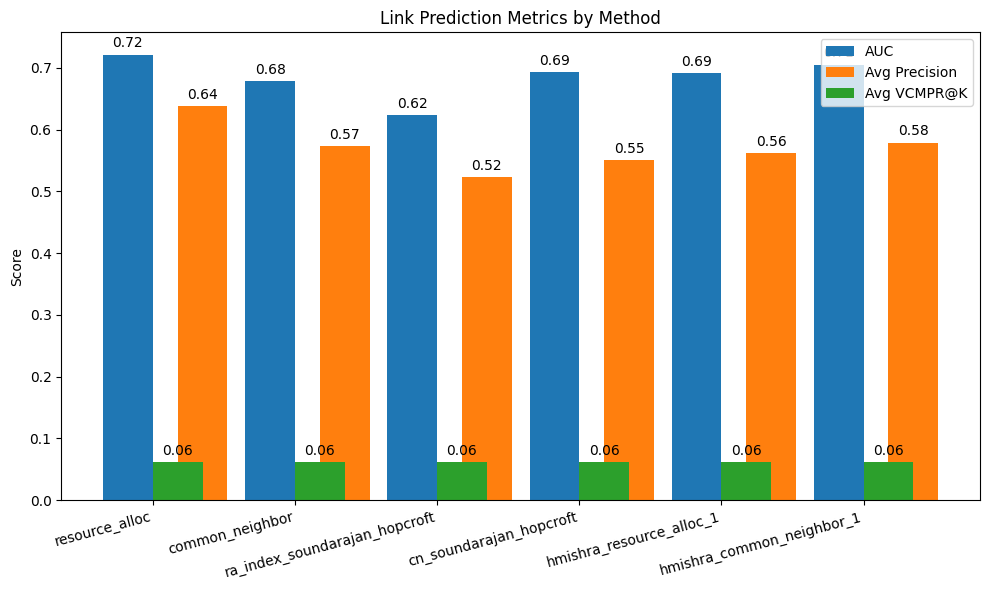

In [18]:
methods = list(results.keys())
auc_scores = [results[m]['auc'] for m in methods]
avg_precisions = [results[m]['avg_precision'] for m in methods]
avg_vcmpr = [results[m]['vcmpr@K'] for m in methods]

x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, auc_scores, width, label='AUC')
bars2 = ax.bar(x + width, avg_precisions, width, label='Avg Precision')
bars3 = ax.bar(x + width/2, avg_vcmpr, width, label='Avg VCMPR@K')


ax.set_ylabel('Score')
ax.set_title('Link Prediction Metrics by Method')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.legend()

for bar in bars1 + bars2 + bars3:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
### CORA

CORA

In [19]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00


In [20]:
from torch_geometric.datasets import Planetoid

In [21]:
pyg_cora = Planetoid(root='/tmp/Cora', name='Cora')[0]
G_full = nx.Graph()
edge_list = pyg_cora.edge_index.t().cpu().numpy()
G_full.add_edges_from(edge_list)

Processing...
Done!


In [22]:
methods_vals_cora = get_baseline_scores(G_full, )
results_cora = {}

for method, metrics in methods_vals_cora.items():
  avg_auc = np.mean(metrics['auc_scores'])
  avg_avg_precision = np.mean(metrics['avg_precision_scores'])
  vcmpr = np.mean(metrics['vcmpr'])

  results_cora[method]={
      'auc':avg_auc,
      'avg_precision': avg_avg_precision,
      'vcmpr@K': vcmpr
  }

fold 1/10
fold 2/10
fold 3/10
fold 4/10
fold 5/10
fold 6/10
fold 7/10
fold 8/10
fold 9/10
fold 10/10


In [24]:
results_cora

{'resource_alloc': {'auc': np.float64(0.7346864616871196),
  'avg_precision': np.float64(0.6472430363992737),
  'vcmpr@K': np.float64(0.05722383968370328)},
 'common_neighbor': {'auc': np.float64(0.8354396411565009),
  'avg_precision': np.float64(0.8072664903874127),
  'vcmpr@K': np.float64(0.05722381595102814)},
 'ra_index_soundarajan_hopcroft': {'auc': np.float64(0.7050392646059314),
  'avg_precision': np.float64(0.6072132028794668),
  'vcmpr@K': np.float64(0.05722383968370328)},
 'cn_soundarajan_hopcroft': {'auc': np.float64(0.7340287342393145),
  'avg_precision': np.float64(0.6411025494406076),
  'vcmpr@K': np.float64(0.057229274466311986)},
 'hmishra_resource_alloc_1': {'auc': np.float64(0.7199555633327038),
  'avg_precision': np.float64(0.6179632724364181),
  'vcmpr@K': np.float64(0.057218381168419444)},
 'hmishra_common_neighbor_1': {'auc': np.float64(0.7338890211054817),
  'avg_precision': np.float64(0.6397979178206719),
  'vcmpr@K': np.float64(0.057229274466311986)}}

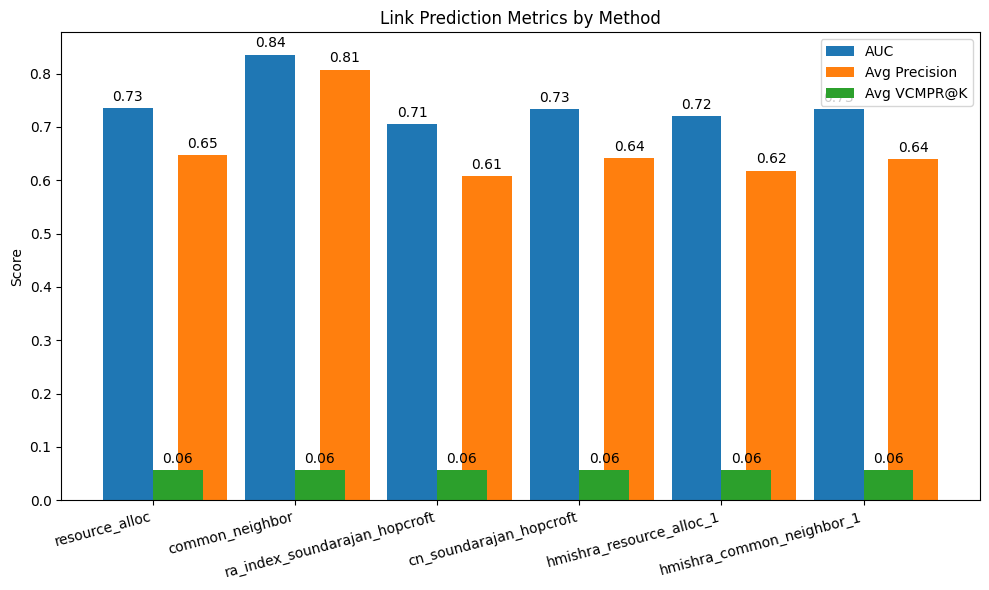

In [23]:
methods = list(results_cora.keys())
auc_scores = [results_cora[m]['auc'] for m in methods]
avg_precisions = [results_cora[m]['avg_precision'] for m in methods]
avg_vcmpr = [results_cora[m]['vcmpr@K'] for m in methods]

x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, auc_scores, width, label='AUC')
bars2 = ax.bar(x + width, avg_precisions, width, label='Avg Precision')
bars3 = ax.bar(x + width/2, avg_vcmpr, width, label='Avg VCMPR@K')


ax.set_ylabel('Score')
ax.set_title('Link Prediction Metrics by Method')
ax.set_xticks(x)
ax.set_xticklabels(methods, rotation=15, ha='right')
ax.legend()

for bar in bars1 + bars2 + bars3:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


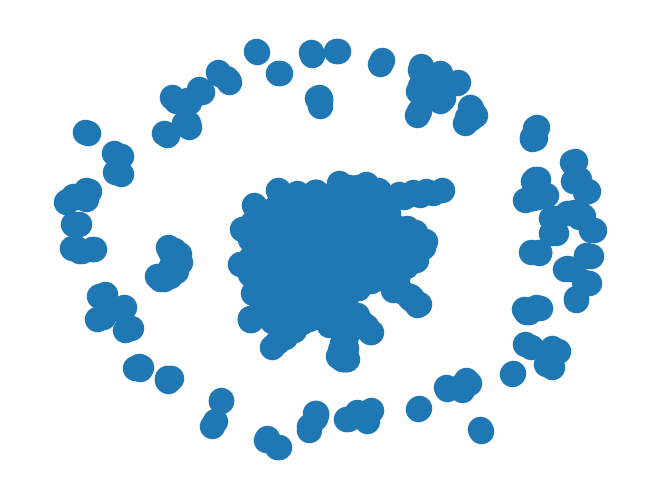

In [ ]:
nx.draw_spring(G_full, with_labels=False)